# DQN

The goal of this exercise is to implement DQN using pytorch and to apply it to the cartpole balancing problem. 

The code is adapted from the Pytorch tutorial: <https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html>.

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !pip install -U gymnasium pygame moviepy swig

In [2]:
# Default libraries
import math
import random
import os
import time
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt
from collections import namedtuple, deque

# Gymnasium
import gymnasium as gym
print("gym version:", gym.__version__)

# pytorch
import torch
import torch.nn.functional as F

# Select hardware: 
if torch.cuda.is_available(): # GPU
    device = torch.device("cuda")
elif torch.backends.mps.is_available(): # Metal (Macos)
    device = torch.device("mps")
else: # CPU
    device = torch.device("cpu")
print(f"Device: {device}")

gym version: 1.0.0
Device: mps


In [3]:
from moviepy.editor import ImageSequenceClip, ipython_display

class GymRecorder(object):
    """
    Simple wrapper over moviepy to generate a .gif with the frames of a gym environment.
    
    The environment must have the render_mode `rgb_array_list`.
    """
    def __init__(self, env):
        self.env = env
        self._frames = []

    def record(self, frames):
        "To be called at the end of an episode."
        for frame in frames:
            self._frames.append(np.array(frame))

    def make_video(self, filename):
        "Generates the gif video."
        directory = os.path.dirname(os.path.abspath(filename))
        if not os.path.exists(directory):
            os.mkdir(directory)
        self.clip = ImageSequenceClip(list(self._frames), fps=self.env.metadata["render_fps"])
        self.clip.write_gif(filename, fps=self.env.metadata["render_fps"], loop=0)
        del self._frames
        self._frames = []

## Cartpole balancing task

We are going to use the Cartpole balancing problem, which can be loaded with:

```python
gym.make('CartPole-v0', render_mode="rgb_array_list")
```

States have 4 continuous values (position and speed of the cart, angle and speed of the pole) and 2 discrete outputs (going left or right). The reward is +1 for each transition where the pole is still standing (angle of less than 30° with the vertical). 

In CartPole-v0, the episode ends when the pole fails or after 200 steps. In CartPole-v1, the maximum episode length is 500 steps, which is too long for us, so we stick to v0 here.

The maximal (undiscounted) return is therefore 200. Can DQN learn this?

Return: 17.0
MoviePy - Building file videos/cartpole_random.gif with imageio.



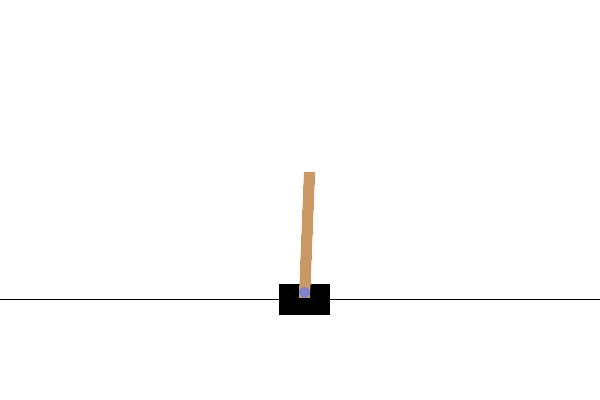

In [4]:
# Create the environment
env = gym.make('CartPole-v0', render_mode="rgb_array_list")
recorder = GymRecorder(env)

# Sample the initial state
state, info = env.reset()

# One episode:
done = False
return_episode = 0
while not done:

    # Select an action randomly
    action = env.action_space.sample()
    
    # Sample a single transition
    next_state, reward, terminal, truncated, info = env.step(action)

    # End of the episode
    done = terminal or truncated

    # Update undiscounted return
    return_episode += reward
    
    # Go in the next state
    state = next_state

print("Return:", return_episode)

recorder.record(env.render())
video = "videos/cartpole_random.gif"
recorder.make_video(video)
ipython_display(video)

## Value network in pytorch

As the state in Cartpole has only four dimensions, we do not need a CNN for the value network. A simple MLP with a couple of hidden layers will be enough.

**Q:** Create a MLP class in pytorch taking four inputs and two outputs (one Q-value per action), and two hidden layers of 128 neurons (you can change it later). If possible, make it parameterizable, i.e. have the constructor take in the number of inputs, outputs and hidden neurons. The activation function for the hidden layers should be ReLU.

In [5]:
class MLP(torch.nn.Module):
    "Value network for DQN on Cartpole."

    def __init__(self, nb_observations, nb_hidden1, nb_hidden2, nb_actions):
        super(MLP, self).__init__()
        
        # Layers
        self.fc1 = torch.nn.Linear(nb_observations, nb_hidden1)
        self.fc2 = torch.nn.Linear(nb_hidden1, nb_hidden2)
        self.fc3 = torch.nn.Linear(nb_hidden2, nb_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

**Q:** Create a network, an environment, get the initial state using `env.reset()` and pass it to the `forward()` method of your NN. What happens?

Do not forget to send the network to your device, especially if you have a GPU. Create the network using something like:

```python
net = MLP(...).to(device)
```

In [6]:
# Create the environment
env = gym.make('CartPole-v0')

# Create the value network
net = MLP(env.observation_space.shape[0], 128, 128, env.action_space.n).to(device)

# Sample the initial state
state, info = env.reset()
print(state)

# Predict the Q-values from the initial state
Q_values = net.forward(state)

[ 0.0224134   0.00670727 -0.03332475 -0.03872823]


TypeError: linear(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

Alright, we need to cast the state vector into a pytorch tensor, pytorch does not do it automatically.

To cast a numpy vector of shape (4,) into a tensor, one simply needs to call:

```python
state = torch.tensor(state, dtype=torch.float32, device=device)
```

The dtype must be set to `torch.float32` for floating numbers. Integers should be set to `torch.long`. Do not forget to send the tensor to your device if you plan to pass it to your network.

**Q:** Pass the new tensor to your network. What is the shape of the output tensor?

In [7]:
# Create the environment
env = gym.make('CartPole-v0')

# Create the value network
net = MLP(env.observation_space.shape[0], 128, 128, env.action_space.n).to(device)

# Sample the initial state
state, info = env.reset()
print(state, state.shape)

# Cast the state to a tensor
state = torch.tensor(state, dtype=torch.float32, device=device)
print(state, state.shape)

# Predict the Q-values from the initial state
Q_values = net.forward(state)
print(Q_values, Q_values.shape)

[0.03727312 0.02480382 0.03185986 0.00359333] (4,)
tensor([0.0373, 0.0248, 0.0319, 0.0036], device='mps:0') torch.Size([4])
tensor([0.0286, 0.0517], device='mps:0', grad_fn=<LinearBackward0>) torch.Size([2])


The value network outputs one Q-value per action, great. Now, let's identify the **greedy** action, i.e. the one with the highest Q-value. The two actions expected by the cartpole environment are 0 and 1, i.e. the index of the element with the highest Q-value as a Python integer. 

Have a look at those two methods of `Tensor`:

* ``Tensor.argmax``: <https://pytorch.org/docs/stable/generated/torch.argmax.html>
* ``Tensor.item``: <https://pytorch.org/docs/stable/generated/torch.Tensor.item.html>

**Q:** Find a way to obtain the index (as a Python integer) of the element with the highest value in the tensor of Q-values. Check that it works. 

In [16]:
greedy_action = Q_values.argmax().item()
print(f"Greedy action: {greedy_action}")

Greedy action: 1


**Q:** Create a dummy agent class (as in the previous exercises) storing a value network and acting using $\epsilon$-greedy action selection. Add a ``test()``method running a few episodes and possibly recording them. 

The constructor should accept several hyperparameters, such as the `config` dictionary in the following skeleton:

```python
class RandomDQNAgent:
    def __init__(self, env, config):
    def act(self, state):
    def test(self, nb_episodes, recorder=None):
```

To prepare ourselves, implement a schedule for `epsilon` in the `act()` method: epsilon should start at a high value of 0.9 and decrease exponentially to 0.05 for each action made. The value of epsilon follows this formula:

$$
    \epsilon = 0.05 + (0.9 - 0.05) * \exp ( - \dfrac{t}{1000})
$$

where t is the number of steps since the start. 0.05, 0.9 and 1000 should be parameters of the class.

In [20]:
class RandomDQNAgent:
    """
    Random deep Q-learning agent.
    """
    
    def __init__(self, env, config):

        self.env = env
        self.config = config
        self.epsilon = self.config['eps_start']

        # Number of actions
        self.n_actions = self.env.action_space.n

        # Number of states
        self.state, info = self.env.reset()
        self.n_observations = len(self.state)

        # Value network
        self.value_net = MLP(self.n_observations, config['nb_hidden'], config['nb_hidden'], self.n_actions).to(device)

        self.steps_done = 0
        
    
    def act(self, state):
        "Returns an action using epsilon-greedy action selection."

        # Decay epsilon exponentially
        self.epsilon = self.config['eps_end'] + (self.config['eps_start'] - self.config['eps_end']) * math.exp(-1. * self.steps_done / self.config['eps_decay'])

        # Keep track of time
        self.steps_done += 1
    
        # epsilon-greedy action selection
        if rng.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                return self.value_net(state).argmax().item()

    
    def test(self, nb_episodes, recorder=None):
        "Performs a test episode without exploration."
        previous_epsilon = self.epsilon
        self.epsilon = 0.0

        for episode in range(nb_episodes):
        
            # Reset
            state, _ = self.env.reset()
            state = torch.tensor(state, dtype=torch.float32, device=device)

            # Sample the episode
            done = False
            return_episode = 0
            while not done:                
                action = self.act(state)
                next_state, reward, terminal, truncated, info = self.env.step(action)
                return_episode += reward
                done = terminal or truncated
                state = torch.tensor(next_state, dtype=torch.float32, device=device)

            print(f"Episode {episode}: return {return_episode}, epsilon: {self.epsilon:.4f}")
            
        self.epsilon = previous_epsilon
            
        if recorder is not None:
            recorder.record(self.env.render())


Episode 0: return 23.0, epsilon: 0.8815
Episode 1: return 12.0, epsilon: 0.8716
Episode 2: return 13.0, epsilon: 0.8610
Episode 3: return 17.0, epsilon: 0.8473
Episode 4: return 23.0, epsilon: 0.8292
Episode 5: return 37.0, epsilon: 0.8009
Episode 6: return 30.0, epsilon: 0.7787
Episode 7: return 23.0, epsilon: 0.7621
Episode 8: return 16.0, epsilon: 0.7508
Episode 9: return 31.0, epsilon: 0.7294
MoviePy - Building file videos/cartpole-random2.gif with imageio.



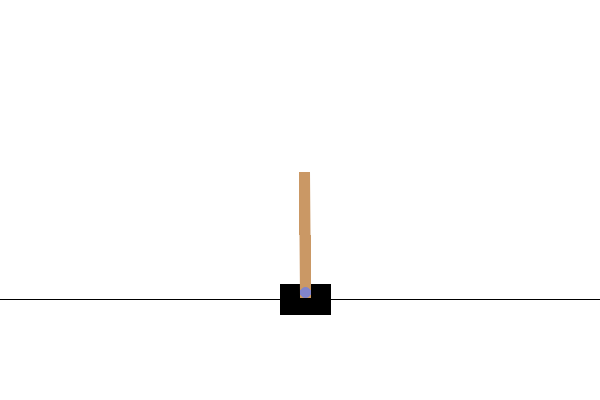

In [21]:
# Create the environment
env = gym.make('CartPole-v0', render_mode="rgb_array_list")
recorder = GymRecorder(env)

# Hyperparameters
config = {}
config['nb_hidden'] = 128 # number of hidden neurons in each layer
config['eps_start'] = 0.9 # starting value of epsilon
config['eps_end'] = 0.05 # final value of epsilon
config['eps_decay'] = 1000 # rate of exponential decay of epsilon, higher means a slower decay

# Create the agent
agent = RandomDQNAgent(env, config)

# Make 10 evaluation episodes
agent.test(10, recorder)

# Show episodes
recorder.record(env.render())
video = "videos/cartpole-random2.gif"
recorder.make_video(video)
ipython_display(video)

## Target network

The original DQN algorithm implies two neural networks:

1. The value network $Q_\theta(s, a)$, learning to predict the Q-values for the current state.
2. The target network $Q_{\theta'}(s, a)$, used to predict the Q-values in the next state.

The target network is a copy of the value network (in terms of structure and parameters), but the update occurs only from time to time.

**Q:** Create two MLPs of the same size and predict the Q-values of a single state. What happens?

In [47]:
# Create the environment
env = gym.make('CartPole-v0')

# Create the value network
value_net = MLP(env.observation_space.shape[0], 128, 128, env.action_space.n).to(device)

# Create the target network
target_net = MLP(env.observation_space.shape[0], 128, 128, env.action_space.n).to(device)

# Sample the initial state
state, _ = env.reset()

# Cast the state to a tensor
state = torch.tensor(state, dtype=torch.float32, device=device)

# Predict the Q-values for both networks
Q_value = value_net.forward(state)
Q_target = target_net.forward(state)

print(Q_value)
print(Q_target)

tensor([-0.0006,  0.0357], device='mps:0', grad_fn=<LinearBackward0>)
tensor([ 0.0151, -0.0160], device='mps:0', grad_fn=<LinearBackward0>)


Obviously, the two MLPs are initialized using random parameters, so they are different. We need a method to copy the weights of a network into another one. 

It is fortunately very easy to save/load the parameters of a pytorch network:

```python
params = net.state_dict()
net.load_state_dict(params)
```

**Q:** Apply these methods to update the weights of the target network with the value one. Check that they now predict the same thing.

In [48]:
# Create the environment
env = gym.make('CartPole-v0')

# Create the value network
value_net = MLP(env.observation_space.shape[0], 128, 128, env.action_space.n).to(device)

# Create the target network
target_net = MLP(env.observation_space.shape[0], 128, 128, env.action_space.n).to(device)

# Update the target network
target_net.load_state_dict(value_net.state_dict())

# Sample the initial state
state, _ = env.reset()

# Cast the state to a tensor
state = torch.tensor(state, dtype=torch.float32, device=device)

# Predict the Q-values for both networks
Q_value = value_net.forward(state)
Q_target = target_net.forward(state)

print(Q_value)
print(Q_target)

tensor([ 0.0105, -0.1769], device='mps:0', grad_fn=<LinearBackward0>)
tensor([ 0.0105, -0.1769], device='mps:0', grad_fn=<LinearBackward0>)


## Experience Replay Memory

The second important component of DQN is the experience replay memory (ERM) or replay buffer. It is a limited size buffer that can store $(s, a, r, s', d)$ transitions, where $d$ is a boolean indicating whether the next state $s'$ is terminal or not (in gymnasium, this is the boolean `done = terminal or truncated`).

Below is a simple implementation of an ERM. The important data structure here is `deque` (double-ended queue) which behaves like a list when `append()` is called, until its capacity is reached (`maxlen`), in which case new elements overwrite older ones. 

`batch = sample(batch_size)` randomly samples a minibatch from the ERM and returns a structure of $(s, a, r, s', d)$ transitions, nicely casted into pytorch tensors. These tensors are accessed with `batch.state`, `batch.action`, etc.

In [33]:
# Named tuples are fancy dictionaries
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory(object):
    "Simple Experience Replay Memory using uniform sampling."

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def append(self, state, action, reward, next_state, done):
        "Appends a transition (s, a, r, s', done) to the buffer."
        # Get numpy arrays
        if isinstance(state, (torch.Tensor,)): state = state.numpy(force=True)
        if isinstance(next_state, (torch.Tensor,)): next_state = next_state.numpy(force=True)
        
        # Append to the buffer
        self.memory.append(Transition(state, action, reward, next_state, done))

    def sample(self, batch_size):
        "Returns a minibatch of (s, a, r, s', done)"
        # Sample the batch
        transitions = random.sample(self.memory, batch_size)
        
        # Transpose the batch.
        batch = Transition(*zip(*transitions))
        
        # Cast to tensors
        states = torch.tensor(batch.state, dtype=torch.float32, device=device)
        actions = torch.tensor(batch.action, dtype=torch.long, device=device)
        rewards = torch.tensor(batch.reward, dtype=torch.float32, device=device)
        next_states = torch.tensor(batch.next_state, dtype=torch.float32, device=device)
        dones = torch.tensor(batch.done, dtype=torch.bool, device=device)

        return Transition(states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

**Q:** Modify your random DQN agent so that it stores a replay buffer of capacity 10000 and appends all transitions into it. Do a few episodes, sample a small minibatch and have a look at the data you obtain.

In [34]:
class RandomDQNAgent:
    """
    Random deep Q-learning agent with memory.
    """
    
    def __init__(self, env, config):

        self.env = env
        self.config = config
        self.epsilon = self.config['eps_start']

        # Number of actions
        self.n_actions = self.env.action_space.n

        # Number of states
        self.state, info = self.env.reset()
        self.n_observations = len(self.state)

        # Value network
        self.value_net = MLP(self.n_observations, config['nb_hidden'], config['nb_hidden'], self.n_actions).to(device)

        # Replay buffer
        self.memory = ReplayMemory(capacity=1000)

        self.steps_done = 0
        
    
    def act(self, state):
        "Returns an action using epsilon-greedy action selection."

        # Decay epsilon exponentially
        self.epsilon = self.config['eps_end'] + (self.config['eps_start'] - self.config['eps_end']) * math.exp(-1. * self.steps_done / self.config['eps_decay'])

        # Keep track of time
        self.steps_done += 1
    
        # epsilon-greedy action selection
        if rng.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                return self.value_net(state).argmax().item()

    
    def test(self, nb_episodes, recorder=None):
        "Performs a test episode without exploration."
        previous_epsilon = self.epsilon
        self.epsilon = 0.0

        for episode in range(nb_episodes):
        
            # Reset
            state, _ = self.env.reset()
            state = torch.tensor(state, dtype=torch.float32, device=device)

            # Sample the episode
            done = False
            return_episode = 0
            while not done:                
                action = self.act(state)
                next_state, reward, terminal, truncated, info = self.env.step(action)
                return_episode += reward
                done = terminal or truncated
                
                # Append the transition to the replay buffer
                self.memory.append(state, action, reward, next_state, done)

                state = torch.tensor(next_state, dtype=torch.float32, device=device)

            print(f"Episode {episode}: return {return_episode}, epsilon: {self.epsilon:.4f}")
            
        self.epsilon = previous_epsilon
            
        if recorder is not None:
            recorder.record(self.env.render())


In [35]:
# Create the environment
env = gym.make('CartPole-v0')

# Hyperparameters
config = {}
config['nb_hidden'] = 128 # number of hidden neurons in each layer
config['eps_start'] = 0.9 # starting value of epsilon
config['eps_end'] = 0.05 # final value of epsilon
config['eps_decay'] = 1000 # rate of exponential decay of epsilon, higher means a slower decay
config['buffer_limit'] = 1000 # maximum number of transitions in the replay buffer

# Create the agent
agent = RandomDQNAgent(env, config)

# Make 10 evaluation episodes
agent.test(10)

Episode 0: return 19.0, epsilon: 0.8848
Episode 1: return 8.0, epsilon: 0.8782
Episode 2: return 51.0, epsilon: 0.8370
Episode 3: return 40.0, epsilon: 0.8061
Episode 4: return 32.0, epsilon: 0.7823
Episode 5: return 12.0, epsilon: 0.7736
Episode 6: return 14.0, epsilon: 0.7635
Episode 7: return 35.0, epsilon: 0.7390
Episode 8: return 19.0, epsilon: 0.7260
Episode 9: return 25.0, epsilon: 0.7093


In [36]:
# Sample the ERM
batch = agent.memory.sample(10)

print("States:", batch.state.shape, batch.state)
print("Actions:", batch.action.shape, batch.action)
print("Rewards:", batch.reward.shape, batch.reward)
print("Next states:", batch.next_state.shape, batch.next_state)
print("Dones:", batch.done.shape, batch.done)


States: torch.Size([10, 4]) tensor([[-8.8130e-03, -1.8004e-01, -1.8154e-02,  2.9670e-01],
        [ 8.2345e-03, -4.3172e-02, -3.3840e-02, -1.3027e-01],
        [-1.5566e-01, -8.1054e-01,  1.9792e-01,  1.4256e+00],
        [-2.2250e-02,  1.5405e-02,  4.4516e-03, -3.2377e-03],
        [ 4.8573e-02,  8.2803e-03, -1.0452e-03,  9.8198e-03],
        [-4.1510e-02, -2.1378e-01,  2.0494e-02,  2.7213e-01],
        [ 2.2593e-02, -4.1378e-01, -2.5314e-02,  6.1285e-01],
        [-1.3218e-02,  1.5322e-02, -7.3846e-03, -1.4009e-03],
        [-1.1026e-01, -7.7357e-01,  1.5540e-01,  1.3686e+00],
        [-4.8141e-02, -2.4915e-01,  7.8527e-02,  4.3004e-01]], device='mps:0')
Actions: torch.Size([10]) tensor([1, 0, 1, 1, 0, 0, 0, 0, 0, 0], device='mps:0')
Rewards: torch.Size([10]) tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='mps:0')
Next states: torch.Size([10, 4]) tensor([[-1.2414e-02,  1.5334e-02, -1.2220e-02, -1.6545e-03],
        [ 7.3711e-03, -2.3779e-01, -3.6446e-02,  1.5155e-01],
      

**Q:** Use the value network stored into your agent to predict the Q-values of all actions for the states contained in the minibatch. Do NOT use a for loop. Check the size of the resulting tensor. 

In [39]:
Q_values = agent.value_net.forward(batch.state)

print(Q_values.shape)
print(Q_values)

torch.Size([10, 2])
tensor([[0.1208, 0.0245],
        [0.0820, 0.0050],
        [0.1191, 0.1216],
        [0.0879, 0.0212],
        [0.0916, 0.0177],
        [0.1140, 0.0217],
        [0.1230, 0.0468],
        [0.0891, 0.0205],
        [0.1215, 0.1166],
        [0.1190, 0.0369]], device='mps:0', grad_fn=<LinearBackward0>)


**Q:** The previous tensors returns the value of all actions in those visited states. We now want only the Q-value of action that was taken (whose index is in `batch.action`). The resulting tensor should therefore a vector of length `batch_size`. How do we do that?

*Hint:* it would take months of practice to master all the indexing methods available in pytorch: <https://pytorch.org/docs/stable/torch.html#indexing-slicing-joining>. Meanwhile, numpy-style indexing could be useful. Check what the following statements do:

```python
N = 10
A = torch.randn((N, 2))
B = torch.randint(0, 2, (N,))
C = A[range(N), B]
```

In [40]:
print(Q_values)
print(batch.action)
Q_taken = Q_values[range(10), batch.action]
print(Q_taken)

tensor([[0.1208, 0.0245],
        [0.0820, 0.0050],
        [0.1191, 0.1216],
        [0.0879, 0.0212],
        [0.0916, 0.0177],
        [0.1140, 0.0217],
        [0.1230, 0.0468],
        [0.0891, 0.0205],
        [0.1215, 0.1166],
        [0.1190, 0.0369]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([1, 0, 1, 1, 0, 0, 0, 0, 0, 0], device='mps:0')
tensor([0.0245, 0.0820, 0.1216, 0.0212, 0.0916, 0.1140, 0.1230, 0.0891, 0.1215,
        0.1190], device='mps:0', grad_fn=<IndexBackward0>)


## DQN agent

In [27]:
class DQNAgent:
    "DQN agent."
    
    def __init__(self, env, config):

        # Parameters
        self.env = env
        self.config = config

        # Number of actions
        self.n_actions = self.env.action_space.n

        # Number of states
        self.state, info = self.env.reset()
        self.n_observations = len(self.state)

        # Value network
        self.value_net = MLP(self.n_observations, config['nb_hidden'], config['nb_hidden'], self.n_actions).to(device)

        # Target network
        self.target_net = MLP(self.n_observations, config['nb_hidden'], config['nb_hidden'], self.n_actions).to(device)

        # Copy the value weights into the target network
        self.target_net.load_state_dict(self.value_net.state_dict())

        # Optimizer
        self.optimizer = torch.optim.Adam(self.value_net.parameters(), lr=self.config['learning_rate'])

        # Loss function
        self.loss_function = torch.nn.MSELoss()
        
        # Replay buffer
        self.memory = ReplayMemory(self.config['buffer_limit'])

        self.steps_done = 0
        self.episode_durations = []


    def act(self, state):

        # Decay epsilon exponentially
        self.epsilon = self.config['eps_end'] + (self.config['eps_start'] - self.config['eps_end']) * math.exp(-1. * self.steps_done / self.config['eps_decay'])

        # Keep track of time
        self.steps_done += 1
    
        # epsilon-greedy action selection
        if rng.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                return self.value_net(state).argmax(dim=0).item()

    def update(self):

        # Only learn when the replay buffer is full enough
        if len(self.memory) < 2 * self.config['batch_size']:
            return
        
        # Sample a batch
        batch = self.memory.sample(self.config['batch_size'])

        # Compute Q(s_t, a) with the current value network.
        #Q_values = self.value_net(batch.state).gather(1, batch.action.unsqueeze(1)).squeeze(1)
        Q_values = self.value_net(batch.state)[range(self.config['batch_size']), batch.action]
        
        # Compute Q(s_{t+1}, a*) for all next states.
        # If the next state is terminal, set the value to zero.
        # Do not compute gradients.
        with torch.no_grad():
            next_Q_values = self.target_net(batch.next_state).max(dim=1).values
            next_Q_values[batch.done] = 0.0

        # Compute the target Q values
        targets = (next_Q_values * self.config['gamma']) + batch.reward

        # Compute loss
        loss = self.loss_function(Q_values, targets)

        # Reinitialize the gradients
        self.optimizer.zero_grad()

        # Backpropagation
        loss.backward()

        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.value_net.parameters(), 100)

        # Optimizer step
        self.optimizer.step()

    def train(self, num_episodes):
        
        for i_episode in range(num_episodes):

            tstart = time.time()

            # Initialize the environment and get its state
            state, _ = self.env.reset()

            # Transform the state into a tensor
            state = torch.tensor(state, dtype=torch.float32, device=device)

            done = False
            steps_episode = 0
            while not done:
                
                # Select an action
                action = self.act(state)
                
                # Perform the action
                next_state, reward, terminated, truncated, _ = env.step(action)
                
                # Terminal state
                done = terminated or truncated

                # Store the transition in memory
                self.memory.append(state, action, reward, next_state, done)

                # Move to the next state
                state = torch.tensor(next_state, dtype=torch.float32, device=device)

                # Perform one step of the optimization (on the policy network)
                self.update()

                # Update of the target network's weights
                if self.steps_done % self.config['target_update_period'] == 0:
                    self.target_net.load_state_dict(self.value_net.state_dict())

                # Finish episode
                steps_episode += 1
                if done:
                    self.episode_durations.append(steps_episode)
                    print(f"Episode {i_episode+1}, duration {steps_episode}, epsilon {self.epsilon:.4f} done in {time.time() - tstart}")

In [28]:
# Hyperparameters
config = {}
config['nb_hidden'] = 128 # number of hidden neurons in each layer
config['batch_size'] = 128 # number of transitions sampled from the replay buffer
config['gamma'] = 0.99 # discount factor
config['eps_start'] = 0.9 # starting value of epsilon
config['eps_end'] = 0.05 # final value of epsilon
config['eps_decay'] = 1000 # rate of exponential decay of epsilon, higher means a slower decay
config['tau'] = 0.005 # update rate of the target network
config['learning_rate'] = 1e-3 # learning rate of the optimizer
config['target_update_period'] = 120 # update period (in steps) of the target network
config['buffer_limit'] = 10000 # maximum number of transitions in the replay buffer

# Create the environment
env = gym.make('CartPole-v0')

# Create the agent
agent = DQNAgent(env, config)

# Train the agent
agent.train(num_episodes=250)


Episode 1, duration 29, epsilon 0.8765 done in 0.018595218658447266
Episode 2, duration 14, epsilon 0.8650 done in 0.010457038879394531
Episode 3, duration 27, epsilon 0.8433 done in 0.015136957168579102
Episode 4, duration 30, epsilon 0.8199 done in 0.01650214195251465
Episode 5, duration 32, epsilon 0.7956 done in 0.01904582977294922
Episode 6, duration 29, epsilon 0.7743 done in 0.018700122833251953
Episode 7, duration 13, epsilon 0.7650 done in 0.00727081298828125
Episode 8, duration 32, epsilon 0.7425 done in 0.019001007080078125
Episode 9, duration 30, epsilon 0.7220 done in 0.01921367645263672
Episode 10, duration 38, epsilon 0.6969 done in 0.14808130264282227
Episode 11, duration 16, epsilon 0.6867 done in 0.11038994789123535
Episode 12, duration 13, epsilon 0.6784 done in 0.08904290199279785
Episode 13, duration 12, epsilon 0.6709 done in 0.08433914184570312
Episode 14, duration 14, epsilon 0.6623 done in 0.09883522987365723
Episode 15, duration 12, epsilon 0.6550 done in 0.08

KeyboardInterrupt: 

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(agent.episode_durations)
plt.xlabel("Episodes")
plt.ylabel("Returns")

NameError: name 'agent' is not defined

<Figure size 1000x600 with 0 Axes>